In [10]:
from __future__ import print_function, division
import numpy as np
from math import sqrt

# Image display/notebook settings
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib notebook

In [2]:
# Modeling binding of a single protein to multiple peptides
npeptides = 10
nprotein_c = 10
Mmat = np.logspace(0, 3, nprotein_c)       # Matrix of protein concentrations
Pt = np.array(([10]*npeptides))    # concentration of each peptide
Kd = np.logspace(0, 2, npeptides)  # Kd for each protein-peptide complex

MPapproxP = np.zeros((len(Mmat), npeptides))
for m in range(len(Mmat)):
    Mt = Mmat[m]  # total protein concentration
    for p in range(npeptides):
        MPapproxP[m,p] = (Pt[p]/Kd[p]) * (Mt / (1 + sum(Pt/Kd)))
        
MPapproxM = np.zeros((len(Mmat), npeptides))
for m in range(len(Mmat)):
    Mt = Mmat[m]  # total protein concentration
    for p in range(npeptides):
        MPapproxM[m,p] = Mt * Pt[p] / (Kd[p] + Mt)

In [3]:
MPfinal= np.zeros((len(Mmat), npeptides))
MPnew = np.zeros( (len(Pt)) )
for m in range(len(Mmat)):
    Mt = Mmat[m]  # total protein concentration
    # initial guess
    if Mt > sum(Pt):
        MP = MPapproxM[m,:]
    else:
        MP = MPapproxP[m,:]
    err = 1
    while err > 0.0001:
        MPsum = sum(MP)
        for p in range(npeptides):
            MPsump = MPsum - MP[p]
            b = MPsump - Mt - Pt[p] - Kd[p]
            c = Pt[p] * (Mt - MPsump)
            MPnew[p] = (-b - sqrt(b**2 - 4*c)) / 2
        err = abs(sum((MP - MPnew)/MPnew))
        MP = (0.1*MPnew + MP) / 1.1
    MPfinal[m,:] = MP

In [4]:
class kshow(object):
    """Kurt's white paper for competive binding.
    
    Assuming substrate (peptide on bead) or complex (protein) concentration in excess.
    
    Parameters
    ----------
    c_substrate : array
        NumPy array of substrate (peptide) concentrations.

    c_complex : array
        NumPy array of complex (protein) concentrations.

    kd_init : int
        Set range max for Kd's starting from 0.

    tol : float
        Set tolerance error.
        Defaults to 1E-4.

    Attributes
    ----------
    result : array
        Returns NumPy array of fit.

    Functions
    ---------
    fit : function
        Function to fit parameters.

    Examples
        --------
        >>> Mmat = np.logspace(0, 3, 20)  # Matrix of protein concentrations, e.g. 20x between 0 to 3 uM.
        >>> Pt = np.array(([10]*10))      # Concentrations of each peptide, e.g. 10x 10 uM.
        >>> test_kshow = ba.kin.kshow(Pt, Mmat, 2, 1E-4)
        >>> test_kshow.fit()
        >>> plt.plot(test_kshow.result)
        ...
    """
    def __init__(self, c_substrate, c_complex, kd_init, tol=1E-4):
        self.n_substrate = len(c_substrate)
        self.n_complex = len(c_complex)
        self.c_substrate = c_substrate
        self.c_complex = c_complex
        self.kds = self.kd_init(kd_init, self.n_substrate)
        self.tol = tol
        
    @property
    def result(self):
        """Return result from fit.
        """
        return self.MPfinal

    def fit(self):
        """Fit solution and save to results. Access result with object.result
        """
        self.MPfinal = np.zeros((self.n_complex, self.n_substrate))
        MPapproxM = self.comp_excess(self.c_complex, self.c_substrate, self.kds)
        MPapproxP = self.comp_excess(self.c_complex, self.c_substrate, self.kds)
        MPnew = np.zeros((self.n_substrate))
        for m in range(self.n_complex):
            Mt = self.c_complex[m]  # total protein concentration
            # initial guess
            if Mt > sum(self.c_substrate):
                MP = MPapproxM[m,:]
            else:
                MP = MPapproxP[m,:]
            err = 1
            while err > self.tol:
                MPsum = sum(MP)
                for p in range(self.n_substrate):
                    MPsump = MPsum - MP[p]
                    b = MPsump - Mt - self.c_substrate[p] - self.kds[p]
                    c = self.c_substrate[p] * (Mt - MPsump)
                    MPnew[p] = (-b - sqrt(b**2 - 4*c)) / 2
                err = abs(sum((MP - MPnew)/MPnew))
                MP = (0.1*MPnew + MP) / 1.1
            self.MPfinal[m,:] = MP
    
    @staticmethod
    def kd_init(kd_init, n_substrate):
        """Initial Kd values
        """
        Kd = np.logspace(0, kd_init, n_substrate)  # Kd for each protein-peptide complex
        return Kd
    
    @staticmethod
    def sub_excess(Mmat, Pt, Kd):
        """Substrate (e.g. peptides on bead) in excess
        """
        MPapproxP = np.zeros((len(Mmat), len(Pt)))
        for m in range(len(Mmat)):
            Mt = Mmat[m]  # total protein concentration
            for p in range(len(Pt)):
                MPapproxP[m,p] = (Pt[p]/Kd[p]) * (Mt / (1 + sum(Pt/Kd)))
        return MPapproxP
    
    @staticmethod
    def comp_excess(Mmat, Pt, Kd):
        """Complex (e.g. added protein concentration) in excess
        """
        MPapproxM = np.zeros((len(Mmat), len(Pt)))
        for m in range(len(Mmat)):
            Mt = Mmat[m]  # total protein concentration
            for p in range(len(Pt)):
                MPapproxM[m,p] = Mt * Pt[p] / (Kd[p] + Mt)
        return MPapproxM

In [5]:
test_class = kshow(Pt, Mmat, 2)
test_class.fit()

<IPython.core.display.Javascript object>


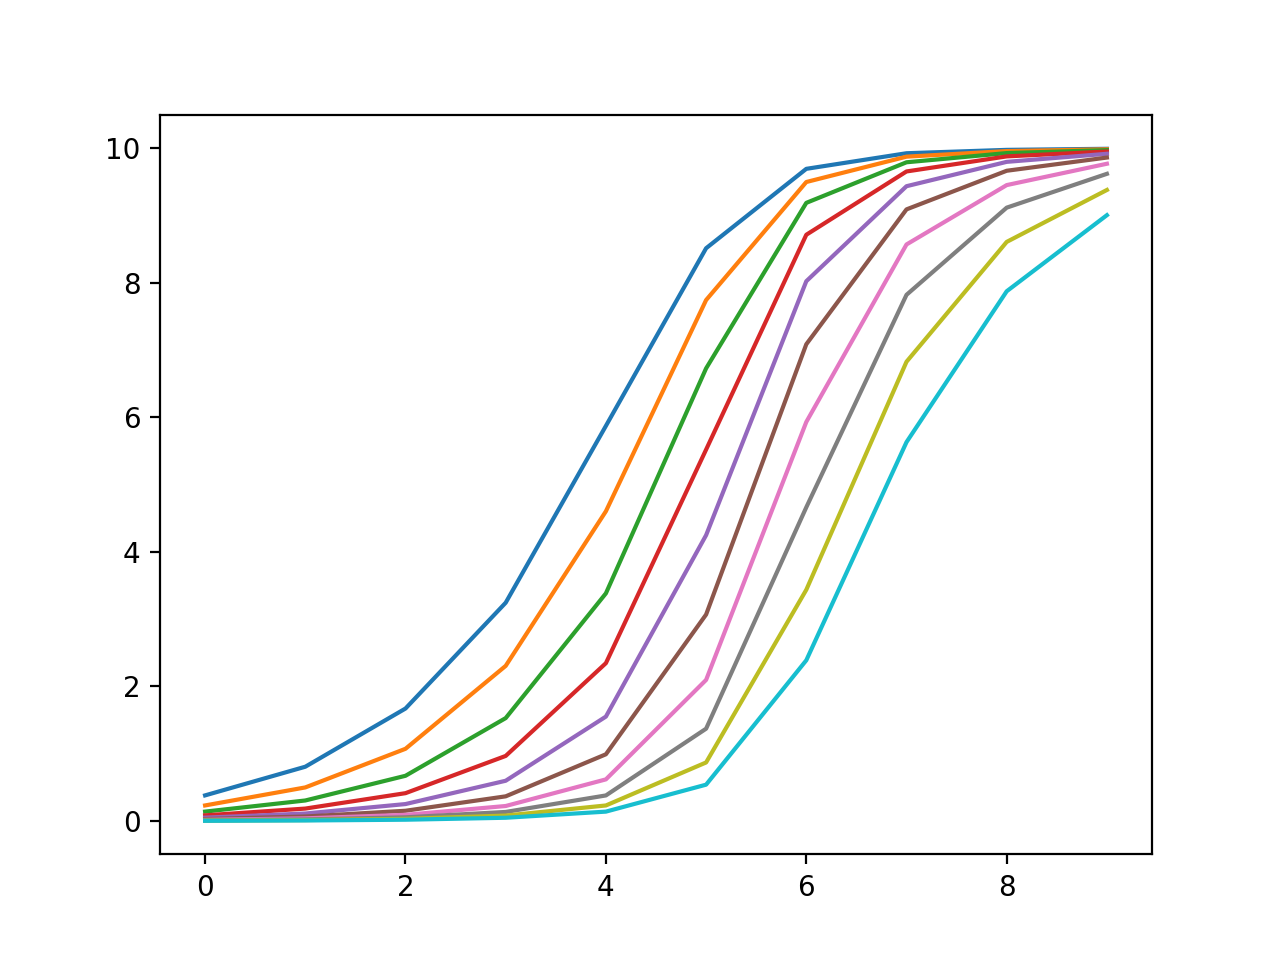

In [11]:
plt.figure()
plt.plot(test_class.result)

In [7]:
import bead_analysis as ba

Copyright 2017 - The Encoded Beads Project - ThornLab@UCSF and FordyceLab@Stanford


<IPython.core.display.Javascript object>


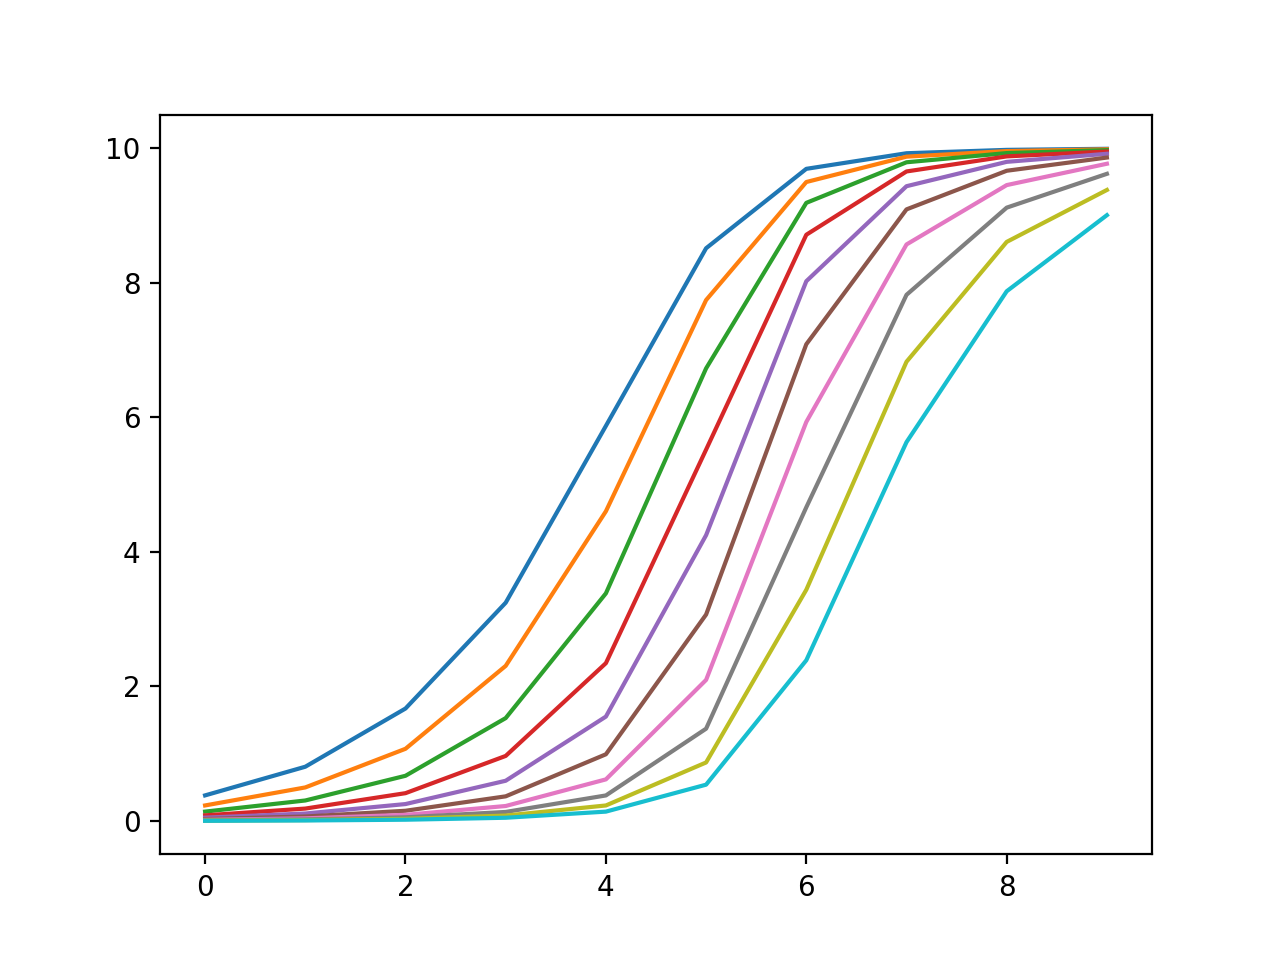

In [12]:
test_module = ba.kinetics.kshow(Pt, Mmat, 2)
test_module.fit()
plt.figure()
plt.plot(test_module.result)